In [1]:
import pylast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

API_KEY = '42d5a344a079b31fdf1e25696a8bd517'
API_SECRET = '02bcec5c2ab24babcc5f5cba374276fb'

network = pylast.LastFMNetwork(api_key=API_KEY, api_secret=API_SECRET)

In [2]:
# Generate a list of users using their friends 
def make_friends_list(initial_user, min_length=1000, friends_list=[], initial_users_list=[]):
    
    # Add initial user to friends list
    friends_list.append(initial_user)
    # Add initial user to list of user "seeds"
    initial_users_list.append(initial_user)
    # Get user's friends
    user = network.get_user(initial_user)
    user_friends = user.get_friends(limit=None)

    # Add friends to user list 
    for i in range(len(user_friends)):
        # Make sure they're not already in the list
        if user_friends[i].get_name() not in friends_list:
            friends_list.append(user_friends[i].get_name()) 
    
    # Find another user whose friends can be added to list
    for i in range(len(friends_list)):
        # Make sure they haven't already been used as a seed
        if friends_list[i] not in initial_users_list:
            new_user = friends_list[i]
    
    # Look at new user's friend's list until list is sufficiently long
    while len(friends_list) < min_length:
        list = make_friends_list(initial_user=new_user, min_length=min_length, friends_list=friends_list, 
                                 initial_users_list=initial_users_list)
    
    # Remove duplicates
    return set(friends_list)

In [3]:
# Create a DataFrame with user, artist, and play count columns
def get_playcounts_from_users(users_list):

    artist_plays_list = []
    users_list = list(users_list)

    # Loop through users
    for user_name in users_list:
        # Get the user's top artists
        user = network.get_user(user_name)
        user_artists = user.get_top_artists()
        
        # For each user and each artist they listen to, create a list containing the username, artist, and play count
        for i in range(len(user_artists)):
            artist_name = user_artists[i]._asdict()['item'].get_name()
            num_plays = int(user_artists[i]._asdict()['weight'])
            artist_list = [user_name, artist_name, num_plays]
            # Create a list of lists containing this info
            artist_plays_list.append(artist_list)
            
    # Create DataFrame 
    df = pd.DataFrame(artist_plays_list)
    df.columns = ['user', 'artist', 'plays']
            
    return df

In [5]:
# Create a DataFrame using jonhdee23 as a seed user
user = 'jonhdee23'
users_list = make_friends_list(user)
playcounts_df = get_playcounts_from_users(users_list)

In [6]:
# Create a pivot table with users as rows, artists as columns, and play counts as values
playcounts_table = playcounts_df.pivot(index='user', columns='artist', values='plays').fillna(0)

# Create a list of total play counts for each artist and sort in descending order
playcounts_per_artist = playcounts_table.sum()
playcounts_per_artist = playcounts_per_artist.sort_values(ascending=False)

In [7]:
# Look at summary statistics, checking for outliers
playcounts_per_artist.describe()

count     14471.000000
mean       2976.466450
std       13739.153824
min           1.000000
25%         180.000000
50%         585.000000
75%        1811.500000
max      846194.000000
dtype: float64

In [8]:
# Assign 25th percentile to bottom_quarter variable
bottom_quarter = playcounts_per_artist.describe()['25%']

# Subset play counts below 25th percentile
playcounts_bottom_quarter = playcounts_per_artist[playcounts_per_artist <= bottom_quarter]

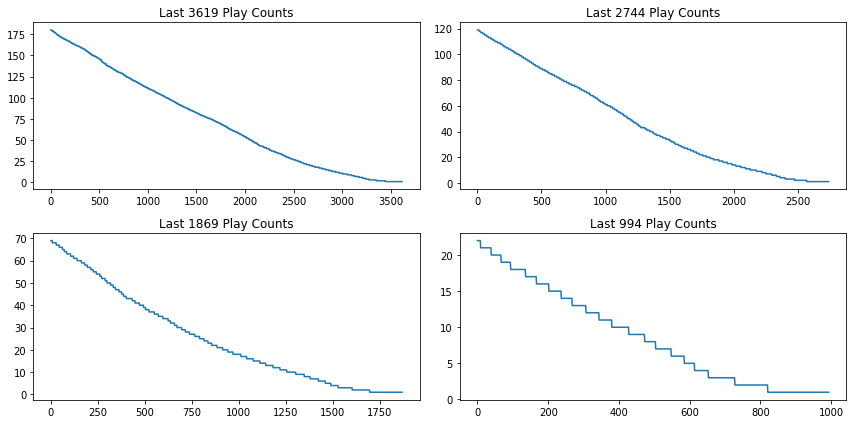

In [9]:
# Round number of values to multiple of 500
num_of_playcounts = len(playcounts_bottom_quarter)
num_of_playcounts_rounded = num_of_playcounts - (num_of_playcounts % 500)
num_of_plots = 4

# Increase width of plots
width = 12
height = 6
plt.figure(figsize=(width, height))

num_of_rows = 2
num_of_cols = 2

# Successfully zoom into plot of bottom quarter of playcounts distribution
for pos_index, xlim in enumerate(np.arange(0, num_of_playcounts_rounded, num_of_playcounts_rounded / num_of_plots)):
    plt.subplot(num_of_rows, num_of_cols, pos_index+1)
    num_of_values = num_of_playcounts - int(xlim)
    plt.title('Last {} Play Counts'.format(num_of_values))
    plt.plot(playcounts_bottom_quarter.values[int(xlim):])
plt.tight_layout()
plt.show()

In [10]:
# Only include artists with a sufficient number of play counts
playcounts_per_artist = playcounts_per_artist[playcounts_per_artist >= bottom_quarter]
# Check how many artists are left 
len(playcounts_per_artist)

10861

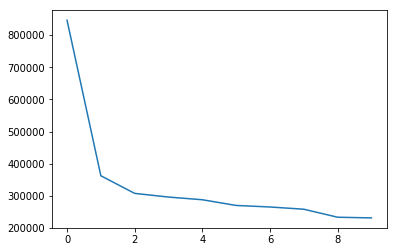

In [11]:
# Plot 10 highest play counts
plt.plot(playcounts_per_artist.values[:10])
plt.show()

In [12]:
playcounts_per_artist[:10]

artist
The Cure                     846194.0
Depeche Mode                 362492.0
Radiohead                    307724.0
Placebo                      296304.0
PJ Harvey                    287961.0
Nine Inch Nails              270227.0
Nick Cave & The Bad Seeds    265436.0
David Bowie                  258482.0
The Beatles                  233617.0
Madonna                      231438.0
dtype: float64

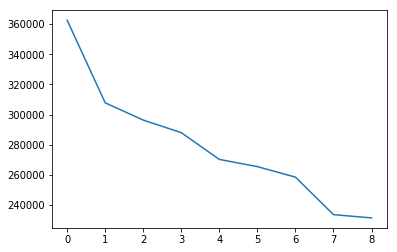

In [13]:
# Plot 9 highest play counts, excluding the highest 
plt.plot(playcounts_per_artist.values[1:10])
plt.show()

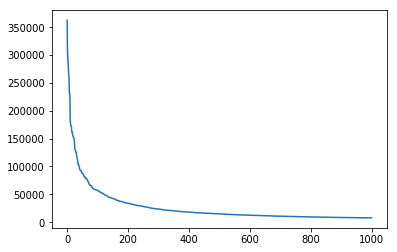

In [14]:
# Plot 1000 highest play counts, excluding the highest
plt.plot(playcounts_per_artist.values[1:1001])
plt.show()

In [15]:
plays_per_user = playcounts_table.sum(1).sort_values(ascending=False)

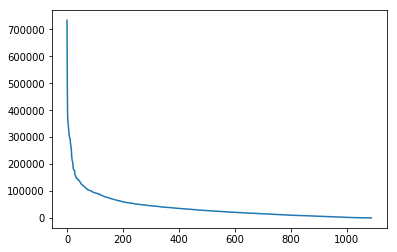

In [16]:
plt.plot(plays_per_user.values)
plt.show()

In [17]:
# Create list of artist names with playcounts above 25th percentile
artists_with_sufficient_playcounts = list(playcounts_per_artist.index)
# Only include those artists in our DataFrame
playcounts_df_original = playcounts_df
playcounts_df = playcounts_df[playcounts_df['artist'].isin(artists_with_sufficient_playcounts)]
# Check that the right number of artists are included
len(playcounts_df['artist'].unique())

10861

In [18]:
scaler = preprocessing.MinMaxScaler()

# Normalize across each artist (users as rows, artists as columns)
df_to_scale = playcounts_table
scaled_across_artists_df = pd.DataFrame(scaler.fit_transform(df_to_scale))
# Label columns using artist names
scaled_across_artists_df.columns = df_to_scale.columns
# Create user column to use when melting
scaled_across_artists_df['user'] = df_to_scale.index
# Melt dataframe to proper format for Surprise library
scaled_across_artists_df = pd.melt(scaled_across_artists_df, id_vars='user', var_name='artist')
# Remove rows with values of 0
scaled_across_artists_df = scaled_across_artists_df[scaled_across_artists_df['value'] != 0]

In [19]:
scaler = preprocessing.MinMaxScaler()

# Normalize across each user (artists as rows, users as columns)
df_to_scale = playcounts_table.transpose()
scaled_across_users_df = pd.DataFrame(scaler.fit_transform(df_to_scale))
# Label columns and index
scaled_across_users_df.columns = df_to_scale.columns
scaled_across_users_df.index = df_to_scale.index
# Transpose dataframe
scaled_across_users_df = scaled_across_users_df.transpose()

# Create user column to use when melting
scaled_across_users_df.reset_index(inplace=True)
# Melt dataframe to proper format for Surprise library
scaled_across_users_df = pd.melt(scaled_across_users_df, id_vars=['user'], var_name='artist')
# Remove rows with values of 0
scaled_across_users_df = scaled_across_users_df[scaled_across_users_df['value'] != 0]

In [20]:
from surprise import Reader, Dataset

reader = Reader(rating_scale=(0,1))
artist_data  = Dataset.load_from_df(scaled_across_artists_df, reader)
user_data = Dataset.load_from_df(scaled_across_users_df, reader)

In [21]:
from surprise import accuracy
from surprise.model_selection import KFold

def get_rmse_scores(algo):
    
    scores = []
    mean_errors = []

    # Define a cross-validation iterator
    kf = KFold(n_splits=5)
    
    # Select which algorithm to use
    algo = algo

    #Get scores for both user scaled and artist scaled data
    for dataset in [user_data, artist_data]:
        
        #Calculate scores for each split
        for trainset, testset in kf.split(dataset):

            # Train and test algorithm
            algo.fit(trainset)
            predictions = algo.test(testset)

            # Store RMSE scores in the 'scores' list
            scores.append(accuracy.rmse(predictions, verbose=False))
        
        #Calculate the mean of the scores and store in 'mean_errors' list
        mean_errors.append(np.mean(scores))
            
    return mean_errors

In [22]:
from surprise import NormalPredictor, BaselineOnly
from surprise import KNNBasic
from surprise import SVD, NMF
from surprise import SlopeOne

rmse_data = []

normal_scores = get_rmse_scores(NormalPredictor())
rmse_data.append(normal_scores)

baseline_scores = get_rmse_scores(BaselineOnly(verbose=False))
rmse_data.append(baseline_scores)

svd_scores = get_rmse_scores(SVD())
rmse_data.append(svd_scores)

nmf_scores = get_rmse_scores(NMF())
rmse_data.append(nmf_scores)

sim_options = {'name': 'cosine', 'user_based': True}
knn_cosine_scores = get_rmse_scores(KNNBasic(sim_options=sim_options, verbose=False))
rmse_data.append(knn_cosine_scores)

sim_options = {'name': 'pearson', 'user_based': True}
knn_pearson_scores = get_rmse_scores(KNNBasic(sim_options=sim_options, verbose=False))
rmse_data.append(knn_pearson_scores)

/home/hussain/anaconda3/lib/python3.6/site-packages/surprise/prediction_algorithms/algo_base.py:293: RuntimeWarning: invalid value encountered in sqrt
  sim = construction_func[name](*args)


In [23]:
rmse_table = pd.DataFrame(rmse_data)
index_names = ['NormalPredictor', 'Baseline', 'SVD', 'NMF', 'User-based cosine-KNN', 'User-based Pearson-KNN']
col_names = ['User scaled', 'Artist scaled']
rmse_table.index = index_names
rmse_table.columns = col_names

In [24]:
rmse_table

,User scaled,Artist scaled
NormalPredictor,0.289497,0.404784
Baseline,0.181984,0.243977
SVD,0.195245,0.251492
NMF,0.206803,0.279166
User-based cosine-KNN,0.224348,0.314802
User-based Pearson-KNN,0.230948,0.315184


In [25]:
def get_recs_table(dataset, algo):

    trainset = dataset.build_full_trainset()

    algo = algo
    algo.fit(trainset)

    predictions = {}
    index_of_users = []
    
    for artist in playcounts_table.columns:
    
        predictions_for_user = []
    
        for user in playcounts_table.index[::2]:
            index_of_users.append(user)
            predictions_for_user.append(algo.predict(user, artist)[3])
            predictions[artist] = predictions_for_user
            
    recs_table = pd.DataFrame(predictions)
    #recs_table.index= index_of_users
    
    return recs_table

In [26]:
predictions_df = get_recs_table(artist_data, KNNBasic(verbose=False))
predictions_df

,!!!,!Action Pact!,!distain,!tch,"""Weird Al"" Yankovic",#Judika www.lagubagus.com,$LUDGEHAMMER,$OUDIERE,$UICIDEBOY$ x RVMIRXZ,$uicideboy$,...,시와무지개,에이오에이,원더걸스 (Wonder Girls),잠비나이,티아라,티아라 & 초신성,폐허,푸른새벽,회사AUTO,２８１４
0,1.000000,1.000000,0.406714,1.000000,0.482117,0.406714,0.406714,1.000000,0.406714,0.068000,...,0.406714,0.406714,0.406714,0.406714,0.406714,0.406714,0.406714,0.406714,1.000000,1.000000
1,1.000000,0.764786,0.406714,0.406714,0.530514,0.406714,1.000000,0.406714,0.406714,0.033130,...,1.000000,0.406714,0.406714,1.000000,0.066232,0.406714,1.000000,1.000000,1.000000,1.000000
2,1.000000,0.529851,1.000000,1.000000,0.358491,0.406714,0.406714,0.406714,0.406714,0.045019,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.406714,1.000000,1.000000,0.406714,1.000000
3,1.000000,0.406714,0.406714,1.000000,0.037855,0.406714,0.406714,1.000000,0.406714,0.080712,...,0.406714,1.000000,1.000000,0.406714,0.533096,0.406714,0.406714,1.000000,0.406714,1.000000
4,1.000000,0.406714,0.406714,0.406714,0.576156,0.406714,0.406714,0.406714,0.406714,0.094978,...,1.000000,1.000000,1.000000,1.000000,0.532659,1.000000,0.406714,0.406714,0.406714,0.406714
5,1.000000,0.406714,0.406714,1.000000,0.636205,0.406714,0.406714,0.406714,0.406714,0.046312,...,1.000000,0.406714,0.406714,1.000000,0.406714,0.406714,1.000000,1.000000,0.406714,1.000000
6,1.000000,0.764838,0.406714,1.000000,0.616629,0.406714,1.000000,1.000000,0.406714,0.131989,...,1.000000,0.406714,0.406714,1.000000,0.066232,0.406714,1.000000,1.000000,1.000000,1.000000
7,1.000000,0.406714,0.406714,0.406714,0.990536,0.406714,0.406714,0.406714,0.406714,0.046743,...,0.406714,0.406714,0.406714,0.406714,0.406714,0.406714,1.000000,0.406714,0.406714,1.000000
8,1.000000,1.000000,0.406714,1.000000,0.809957,1.000000,1.000000,1.000000,0.406714,0.083412,...,1.000000,1.000000,1.000000,1.000000,0.385031,1.000000,1.000000,1.000000,1.000000,0.406714
9,0.406714,0.406714,0.406714,0.406714,0.406714,0.406714,1.000000,1.000000,0.406714,0.132489,...,0.406714,0.406714,0.406714,0.406714,0.406714,0.406714,0.406714,0.406714,0.406714,0.406714


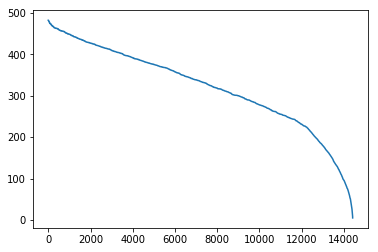

In [27]:
pred_playcounts = predictions_df.sum()
pred_playcounts = pred_playcounts.sort_values(ascending=False)
plt.plot(pred_playcounts.values[50:])
plt.show()

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [1, 10, 25, 50, 100, 200], 'lr_all' : [0.005, 0.01, 0.025, 0.005]}
svd = GridSearchCV(SVD, param_grid, cv=3)
#trainset = user_data.build_full_trainset()
svd.fit(artist_data)
svd.best_params